In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка

In [ ]:
!pip install pymorphy2[fast]
!pip install bigartm10
!pip install pyLDAvis
!pip install natasha
import pyLDAvis
import pyLDAvis.sklearn
import pandas as pd
import pymorphy2
import razdel
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from natasha import MorphVocab
morph = MorphVocab()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Russian_news_project/final_project/csv/TG_2508.csv', index_col=['Unnamed: 0']).reset_index(drop = True)

In [ ]:
df_original = pd.read_csv('/content/drive/MyDrive/Russian_news_project/final_project/csv/df_bez_swNER.csv', index_col=['Unnamed: 0']).reset_index(drop = True)

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('russian')
a = pd.read_csv('/content/drive/MyDrive/Russian_news_project/final_project/stop_words/стоп-слова.txt')
add_stop_words = [i for i in a['STOPWORDS_RUS'] if i not in sw]
sw = sw + add_stop_words
len(sw)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


649

## Предобработка текста

In [ ]:
df["text"][67]

'У Владимира Меньшова двухсторонняя пневмония третья стадия дыхательной недостаточности Родственники режиссера вызвали скорую утром июня Прибывшие медики заметили низкий показатель сатурации отвезли Владимира Валентиновича ГКБ Сегодня скончался больнице'

### К нижнему регистру

In [ ]:
df["text"] = [str(i) for i in df["text"]]
df["text"] = df["text"].map(lambda x: x.lower())
df["text"][67]

'у владимира меньшова двухсторонняя пневмония третья стадия дыхательной недостаточности родственники режиссера вызвали скорую утром июня прибывшие медики заметили низкий показатель сатурации отвезли владимира валентиновича гкб сегодня скончался больнице'

### Морфологический анализ

In [ ]:
df['text'] = df['text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))

In [ ]:
df["text"][67]

'у владимир меньшов двухсторонний пневмония третий стадия дыхательный недостаточность родственник режиссёр вызвать скорый утром июнь прибыть медик заметить низкий показатель сатурация отвезти владимир валентинович гкб сегодня скончаться больница'

### Ещё раз убираем стоп-слова

In [ ]:
df["text"] = [" ".join([word for word in indent.split() if word not in sw]) for indent in df["text"]]

In [ ]:
df["text"][67]

'владимир меньшов двухсторонний пневмония стадия дыхательный недостаточность родственник режиссёр вызвать скорый утром прибыть медик заметить низкий показатель сатурация отвезти владимир валентинович гкб скончаться больница'

### Токенизируем

In [ ]:
def tokenize(text):
    return [token.text for token in razdel.tokenize(text) if len(token.text) > 1]

In [ ]:
df['text'] = df['text'].map(tokenize)

### Создаём колонку с читаемой датой (YYYY-MM-DD)

In [ ]:
df["Date_1"] = pd.to_datetime(df["Date"])

In [ ]:
# df_02_22 = df[df["Date"] <= "2022-02-22"]

### Создаем список для модели

In [ ]:
text_list = df['text'].map(lambda x: np.str_(x))

In [ ]:
# text_list = df_02_22['text'].map(lambda x: np.str_(x))

## LDA

In [ ]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 10000 #количество фичей
n_components = 6 #количество топиков
n_top_words = 15 #количество слов в одном топике
batch_size = 128
init = "nndsvda"

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 2, figsize=(60, 40), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    fig.savefig(f"/content/drive/MyDrive/Russian_news_project/final_project/Model/fig_lda_{n_components}_topics.png")

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.25, min_df=50, max_features=n_features, ngram_range = (1,2))
tfidf = tfidf_vectorizer.fit_transform(text_list)

In [ ]:
representation = tfidf.todense()
print(f'Размерость матрицы : {representation.shape}')
print("Разряженность: ", round((100 -((representation > 0).sum()/representation.size)*100),4), "%")

Размерость матрицы : (102811, 9018)
Разряженность:  99.7429 %


In [ ]:
lda = LatentDirichletAllocation(learning_decay = 0.5, n_components=n_components, max_iter=25, learning_method="online", learning_offset=50.0, random_state=0)
lda.fit(tfidf)

LatentDirichletAllocation(learning_decay=0.5, learning_method='online',
                          learning_offset=50.0, max_iter=25, n_components=6,
                          random_state=0)

In [ ]:
tf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, f"Topics in LDA model (tfidfvectorizer) - {n_components} topics")

In [ ]:
tf_feature_names

array(['17', '20', '200', ..., 'ящик', 'ёлка', 'ёмкость'], dtype=object)

In [ ]:
import joblib
#cохраняем модель
# joblib.dump(tf_feature_names, '/content/drive/MyDrive/Russian_news_project/final_project/Model/tf_feature_names.pkl')
# joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/Russian_news_project/final_project/Model/tfidf_vectorizer.pkl')
# joblib.dump(lda, '/content/drive/MyDrive/Russian_news_project/final_project/Model/model_lda.pkl')
# joblib.dump(tfidf, '/content/drive/MyDrive/Russian_news_project/final_project/Model/tfidf.pkl') 


In [ ]:
# #загружаем модель
# lda = joblib.load("/content/drive/MyDrive/Russian_news_project/final_project/Model/model_lda.pkl")

## [Visualizing LDA Features](https://www.kaggle.com/code/infamouscoder/lda-topic-modeling-features)

### Загружаем модель

In [ ]:
import joblib

In [ ]:
tf_feature_names = joblib.load('/content/drive/MyDrive/Russian_news_project/final_project/Model/tf_feature_names.pkl')
tfidf_vectorizer = joblib.load('/content/drive/MyDrive/Russian_news_project/final_project/Model/tfidf_vectorizer.pkl')
lda = joblib.load('/content/drive/MyDrive/Russian_news_project/final_project/Model/model_lda.pkl')
tfidf = joblib.load('/content/drive/MyDrive/Russian_news_project/final_project/Model/tfidf.pkl') 

### Визуализируем данные

In [ ]:
W1 = lda.transform(tfidf)
H1 = lda.components_

In [ ]:
# Печатает n_top_words лучших релевантных слов для каждой из n_components тем

vocab = np.array(tf_feature_names)

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

topics

['госдума школа депутат публиковать выборы детский партия родитель арест комитет обыск актив протокол иван символика',
 'задержать полиция суд уголовный сотрудник полицейский девушка мужчина признать возбудить статья летний парень ск бывший',
 'пострадать взрыв погибнуть местный пожар житель мужчина произойти больница ребёнок здание предварительный видео данные водитель',
 'российский путин компания украина сша санкция президент рубль рф зеленский банк 200 глава решение цена',
 'самолёт аэропорт кадыров вертолёт борт рейс полёт чечня университет авиакомпания экипаж коронавирус чеченский турист заболеть',
 'украинский украина военный рф днр киев российский всу минобороны лнр обстрел территория войско спецоперация мариуполь']

In [ ]:
#к какой теме/кластеру принадлежит текущий документ (argmax)

colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = [i for i in range(len(text_list))]

df_doc_topic_pos = pd.DataFrame(np.round(W1,2),columns=colnames,index=docnames)
significanttopic = np.argmax(df_doc_topic_pos.values,axis=1)

df_doc_topic_pos['dominant_topic'] = significanttopic
df_doc_topic_pos

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
0,0.03,0.12,0.44,0.35,0.03,0.03,2
1,0.04,0.04,0.04,0.04,0.80,0.04,4
2,0.06,0.15,0.14,0.53,0.04,0.07,3
3,0.05,0.09,0.51,0.30,0.02,0.02,2
4,0.27,0.19,0.18,0.20,0.13,0.03,0
...,...,...,...,...,...,...,...
102806,0.10,0.34,0.06,0.43,0.03,0.03,3
102807,0.11,0.10,0.61,0.09,0.06,0.03,2
102808,0.02,0.02,0.16,0.61,0.12,0.06,3
102809,0.06,0.23,0.05,0.61,0.02,0.02,3


In [ ]:
df_new = pd.read_csv('/content/drive/MyDrive/Russian_news_project/final_project/csv/df_new_2508.csv', index_col=['Unnamed: 0'])

In [ ]:
dict_6 = {3: '4_Россия и МИР', 5: '6_Военные конфликты', 1: '2_Криминал', 2: '3_ЧС', 4: '5_Авиация и covid', 0: '1_Законопроекты'}

In [ ]:
df_new['topic'] = df_new['dominant_topic'].map(dict_6)
df_new.drop(columns=['dominant_topic'], inplace=True)

In [ ]:
df_new.to_csv('/content/drive/MyDrive/Russian_news_project/final_project/csv/final_df.csv')

In [ ]:
d = pd.read_csv('/content/drive/MyDrive/Russian_news_project/final_project/csv/final_df.csv', index_col=['Unnamed: 0'])

In [ ]:
d.tail(25)

,name,Date,text,krasivi_text,organizations,locations,persons,topic
102786,Baza,2022-06-29,Аэрофлот придумал избавиться возрастных бортпр...,"«Аэрофлот» придумал, как избавиться от возраст...",['Аэрофлот'],[],[],4_Россия и МИР
102787,Baza,2022-06-29,На Каширском шоссе Москве крупный пожар Он нач...,На Каширском шоссе в Москве крупный пожар. Он ...,[],"['Москва', 'Каширский Двор', 'Каширское шоссе']",[],3_ЧС
102788,Baza,2022-06-29,Запутывала жаба гадюку начальник отдела полици...,Запутывала жаба гадюку: начальник отдела полиц...,"['УГРО', 'ФСБ', 'ОМВД']","['Елец', 'РФ']","['Пикалова', 'Запутывала', 'Алексей Пикалов', ...",2_Криминал
102789,Baza,2022-06-29,Драка Новосибирске закончилась падением крыши ...,Драка в Новосибирске закончилась падением с кр...,['ТЦ «Юбилейный»'],['Новосибирск'],[],3_ЧС
102790,Baza,2022-06-29,В аэропорту Казани задержали мужчину планирова...,"В аэропорту Казани задержали мужчину, который ...",['ФСБ'],"['Армения', 'Киев', 'Грузия', 'РФ', 'Казань', ...","['Алексей Арестович', 'Арестовича']",2_Криминал
102791,Baza,2022-06-29,Финляндию Швецию принимают НАТО Теперь блок на...,Финляндию и Швецию принимают в НАТО. Теперь бл...,"['НАТО', 'Североатлантический альянс', 'Рабоча...","['Финляндия', 'Швеция', 'Европа', 'Украина', '...",['Йенс Столтенберг'],4_Россия и МИР
102792,Baza,2022-06-29,Четыре тысячи медработница позвонила федеральн...,Четыре тысячи раз медработница позвонила в фед...,"['Минздрав', 'Федеральный центр']",['Москва'],['Елена'],4_Россия и МИР
102793,Baza,2022-06-29,РБК написали ВДНХ прошёл Fashion Tech Run забе...,"РБК написали, что на ВДНХ прошёл Fashion Tech ...","['ВДНХ', 'РБК']",[],[],4_Россия и МИР
102794,Baza,2022-06-29,Я молилась глаза вытекли наружу Русская таксис...,"«Я молилась, чтобы мои глаза не вытекли наружу...",[],['Лас-Вегас'],"['Виктории', 'Виктория']",2_Криминал
102795,Baza,2022-06-29,Которые вернулись нашу Родину погибли умерли с...,"«Которые потом вернулись на нашу Родину, но по...",[],"['Дагестанские Огней', 'Украина']",['Джалалутдин Алирзаев'],4_Россия и МИР


In [ ]:
Ёdom_topic = df_doc_topic_pos['dominant_topic']
df_new = pd.concat([df_new,dom_topic], axis = 1)
df_new

,Unnamed: 0,name,Date,text,krasivi_text,organizations,locations,persons,dominant_topic
0,0,Mash,2021-07-01,Человек своим телом закрыл старого друга семьи...,Человек своим телом закрыл старого друга семьи...,[],[],[],2
1,1,Mash,2021-07-01,Данные коронавирусу прошедшие новых случая За ...,Данные по коронавирусу за прошедшие сутки: 23 ...,[],"['Москва', 'Подмосковье']",[],4
2,2,Mash,2021-07-01,Яша артиллерист вчерашней прямой линии жаловал...,"""Яша-артиллерист"" со вчерашней прямой линии жа...","['Яша-артиллерист', 'СУЭНКО']","['Тюменская область', 'Демьянка']","['Тарлан Тагиров', 'Яши-артиллериста', 'Тагиров']",3
3,3,Mash,2021-07-01,В Москве врачи спасли летней женщине Два часа ...,В Москве врачи спасли жизнь 67-летней женщине....,[],['Москва'],[],2
4,4,Mash,2021-07-01,Мы подумали В ресторане Якутске ребёнку налили...,"""Мы подумали, что это вода"" , 'В ресторане в Я...",['Чочур Муран'],['Якутск'],[],0
...,...,...,...,...,...,...,...,...,...
102806,102806,Baza,2022-06-30,Галочка фейков ВКонтакте тестирует процедуру д...,Галочка против фейков. «ВКонтакте» тестирует п...,['ВКонтакте'],[],[],3
102807,102807,Baza,2022-06-30,В Якутске трое мужчин попытались спасти ребенк...,В Якутске трое мужчин попытались спасти ребенк...,[],['Якутск'],[],2
102808,102808,Baza,2022-06-30,С московских причалов начали убирать зазывал В...,С московских причалов начали убирать зазывал. ...,['Центр организация дорожное движение'],['Москве-реке'],[],3
102809,102809,Baza,2022-06-30,Девушка Москвы перевела рублей мошенникам публ...,Девушка из Москвы перевела 30 миллионов рублей...,['Ватсап'],"['Москва', 'Одинцово']","['Даниэла', 'Даниэлы']",3


In [ ]:
df_new.to_csv('/content/drive/MyDrive/Russian_news_project/final_project/csv/df_new_2508.csv')

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.070613  0.091809       1        1  39.252506
5      0.179094  0.015463       2        1  18.762145
1      0.108652  0.166988       3        1  15.921873
2      0.129453 -0.106301       4        1  12.445182
0     -0.352901  0.166496       5        1   7.390082
4     -0.134911 -0.334455       6        1   6.228212, topic_info=              Term         Freq        Total Category  logprob  loglift
6879       самолёт   778.000000   778.000000  Default  30.0000  30.0000
8178       украина  1775.000000  1775.000000  Default  29.0000  29.0000
8219    украинский  1266.000000  1266.000000  Default  28.0000  28.0000
1025       военный  1132.000000  1132.000000  Default  27.0000  27.0000
5642    пострадать   647.000000   647.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
5887  пресс служба   178.306679   211.906099   Topic6  -5.0284   2.6034
3145   коронавирус   211.574376   316.785829   Topic6  -4.8573   2.3724
1083     воздушный   176.633563   237.490776   Topic6  -5.0378   2.4800
4967      пассажир   152.192887   283.527190   Topic6  -5.1867   2.1539
8306        упасть   150.454093   258.798959   Topic6  -5.1982   2.2337

[293 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2         1  0.998492           200
3         1  0.996733       200 200
168       4  0.995391        авария
173       6  0.995117  авиакомпания
190       4  0.997339       автобус
...     ...       ...           ...
8831      3  0.995084         штраф
8857      6  0.995375        экипаж
8860      1  0.996928     экономика
8867      3  0.995668           экс
8937      4  0.996270          этаж

[366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 3, 1, 5])

In [ ]:
df_original['topic'], df_original['keywords'] = significanttopic, significanttopic

df_original['keywords'] = df_original['keywords'].map({num:topics[num] for num in range(len(topics))})


In [ ]:
# [i.split()[:3] for i in df_original['keywords']]

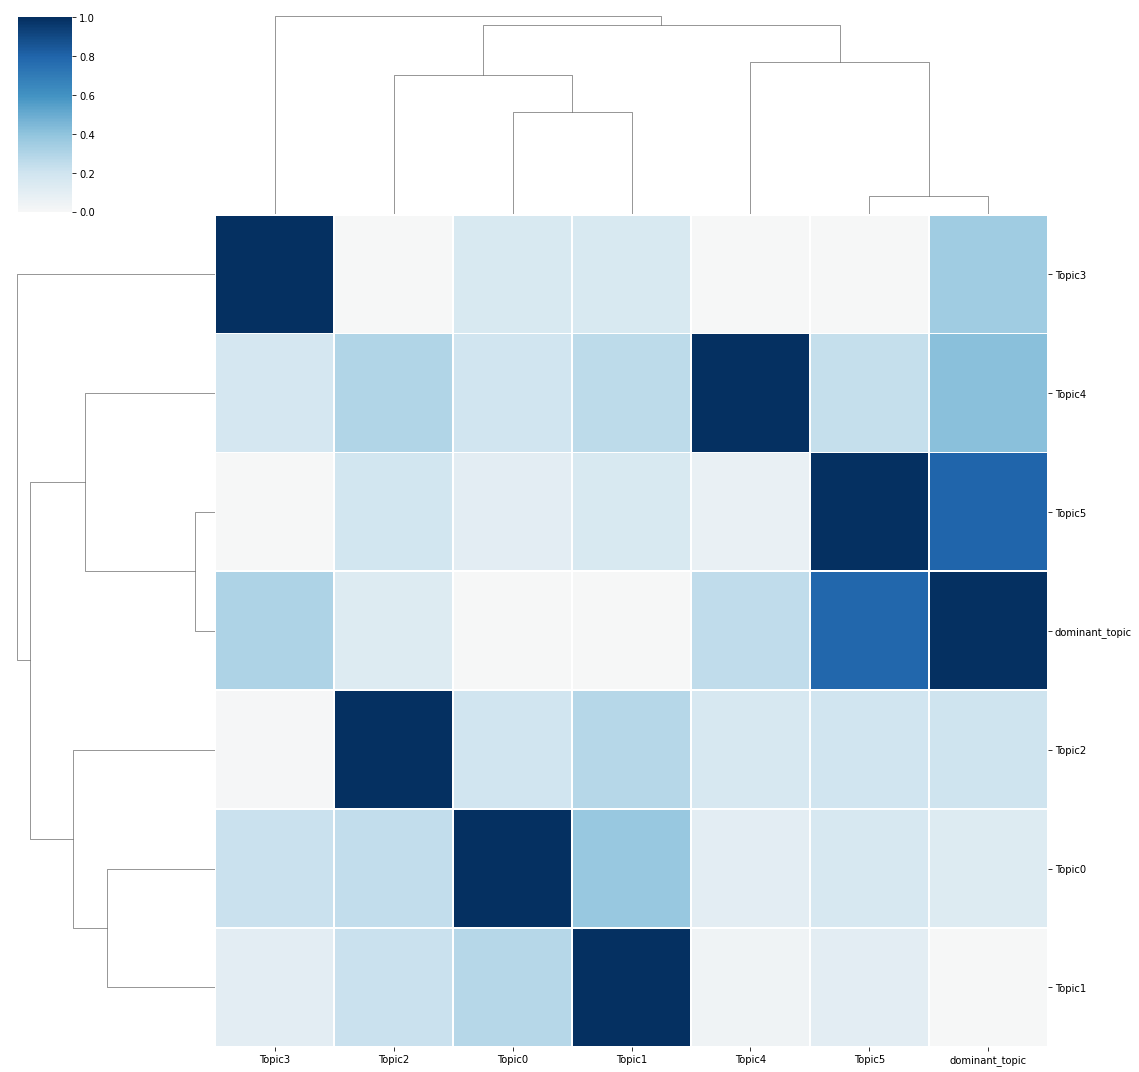

In [ ]:
g=sns.clustermap(df_doc_topic_pos.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

## Эксперименты

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):

    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1
    words = [word[0] for word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

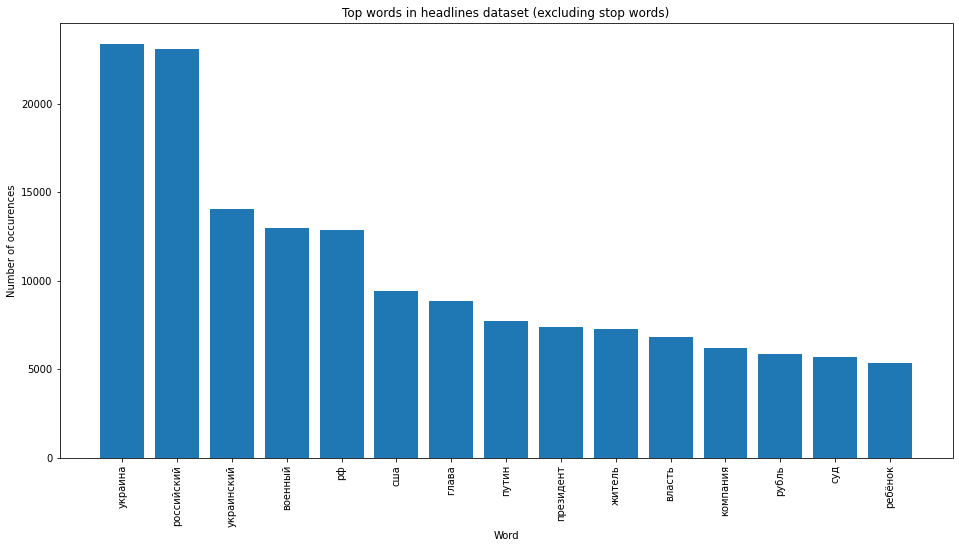

In [ ]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=text_list)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [ ]:
import plotly as py
import plotly.graph_objs as go

w = pd.read_csv('/content/drive/MyDrive/Russian_news_project/final_project/csv/TG_13.08.csv', index_col=['Date'], parse_dates=['Date'], dayfirst=True).drop(columns=['Unnamed: 0']).sort_index()
time = w.index

trace = go.Histogram(
    x=time,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title=' Количество новостей за год',
    height=450,
    width=1200,
    xaxis=dict(
        title='Дата'
    ),
    yaxis=dict(
        title='Количество новостей в день'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
import squarify

df_original['bar_1'] = [i[:-3] for i in df_original['Date']]

x = 0.
y = 0.
width = 50.
height = 50.
type_list = list(df_original['name'].unique())
values = [len(df_original[df_original['name'] == i]) for i in type_list]

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

color_brewer = ['#99B2DD','#F9DEC9','#3A405A','#494949','#FF5D73','#7C7A7A', '#99ddb1', '#3f3d8a', '#f51448', '#3f543f', '#c77204', '#dcf3f5']
shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append( 
        dict(
            type = 'rect', 
            x0 = r['x'], 
            y0 = r['y'], 
            x1 = r['x']+r['dx'], 
            y1 = r['y']+r['dy'],
            line = dict( width = 2 ),
            fillcolor = color_brewer[counter]
        ) 
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            y = r['y']+(r['dy']/2),
            text = "{}-{}".format(type_list[counter], values[counter]),
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(color_brewer):
        counter = 0

# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects ], 
    y = [ r['y']+(r['dy']/2) for r in rects ],
    text = [ str(v) for v in values ], 
    mode = 'text',
)
        
layout = dict(
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest',
    font=dict(color="#FFFFFF")
)

# With hovertext
figure = dict(data=[trace0], layout=layout)
iplot(figure, filename='squarify-tree')

## GridSearch the best LDA

In [ ]:
# # Log Likelyhood: Higher the better
# print("Log Likelihood: ", lda.score(tfidf))

# # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
# print("Perplexity: ", lda.perplexity(tfidf))

# # See model parameters
# print(lda.get_params())

In [ ]:
# from sklearn.model_selection import GridSearchCV

In [ ]:
# # Define Search Param
# search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# # Init the Model
# lda = LatentDirichletAllocation()

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)

# # Do the Grid Search
# model.fit(tfidf)

In [ ]:
# lda = LatentDirichletAllocation(
#     n_components=n_components,
#     max_iter=25,
#     learning_method="online",
#     learning_offset=50.0,
#     random_state=0)

In [ ]:
# GridSearchCV(cv=None, error_score='raise',
#        estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#              evaluate_every=-1, learning_method="online",
#              learning_offset=50.0, max_doc_update_iter=100, max_iter=25,
#              mean_change_tol=0.001, n_jobs=1, perp_tol=0.1, random_state=0,
#              topic_word_prior=None, verbose=0),
#              param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
#              pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#              scoring=None, verbose=0)

In [ ]:
# # Best Model
# best_lda_model = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(tfidf))